In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

sys.path.append('../src')
from sim import make_dataset
from utils import show_dataset

In [247]:
def build(method):
    @wraps(method)
    def wrap(cls, *args, **kwargs):
        if hasattr(cls, '_build'):
            n_args, defaults = len(args) + 1, method.__defaults__
            method_vars, build_vars = method.__code__.co_varnames, cls._build.__code__.co_varnames
            arg_names, kwarg_names = method_vars[1:n_args], method_vars[n_args:n_args + len(defaults)]
            build_args = {key:val for key, val in zip(kwarg_names, defaults) if key in build_vars}
            build_args.update({key:val for key, val in zip(arg_names, args) if key in build_vars})
            build_args.update({key:val for key, val in kwargs.items() if key in build_vars})
            cls._build(**build_args)

        return method(cls, *args, **kwargs)
    return wrap

In [ ]:
import numpy as np
import pyro
import pyro.distributions.constraints as constraints
import torch
from functools import wraps, singledispatch
from pyro.distributions import Categorical, Dirichlet
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.spatial.distance import cdist
from scipy.stats import mode
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
from sklearn.utils import check_array
from tqdm import tqdm
from utils import kmeans, relabel

class GibbsLDA(ClusterMixin, BaseEstimator):
    """Adaptation of latent Dirichlet allocation for point cloud clustering
    using collapsed Gibbs sampling. Based on:
    
    https://papers.nips.cc/paper/2070-latent-dirichlet-allocation
    https://doi.org/10.1073/pnas.0307752101

    Parameters
    ----------
    n_topics : int, default=3
        Number of discoverable topics.
    vocab_size : int, default=10
        Size of word vocabulary.
    doc_size : int, default=10
        Size of each document.
    dt_prior : float, default=1.0
        Document-topic Dirichlet prior.
    tw_prior : float, default=1.0
        Topic-word Dirichlet prior.
    random_state : int, default=None
        Random state seed.

    Attributes
    ----------
    labels_ : ndarray of shape=(n_samples,)
        TODO
    log_ : list of shape=(n_steps,)
        TODO

    Usage
    -----
    >>> model = GibbsLDA(*args, **kwargs)
    >>> topics = model.fit_predict(data, *args, **kwargs)
    """
    def __init__(self, n_topics=3, *, vocab_size=10, doc_size=10, dt_prior=1., tw_prior=1., random_state=None):
        super().__init__()

        self.n_topics = n_topics
        self.vocab_size = vocab_size
        self.doc_size = doc_size
        self.dt_prior = dt_prior
        self.tw_prior = tw_prior
        self.random_state = random_state

        self._step = 0
        
    def _build(self, X, n_steps=100):
        self.n_features_in_, self.log_ = X.shape[-1], []
        knn = cdist(X, X).argsort(-1)[:, :self.doc_size]
        self._docs = kmeans(X, self.vocab_size, verbosity=0)[knn]
        self._words = self._docs.flatten()
        topics = np.random.choice(self.n_topics, self._words.shape[0])
        self._topics = np.zeros((n_steps, self._words.shape[0]), dtype=np.int32)
        self._topics[-1:] = topics
        self._dt_counts = np.eye(self.n_topics)[topics.reshape(*self._docs.shape)].sum(1)
        self._tw_counts = (topics == np.arange(self.n_topics)[None].T)@np.eye(self.vocab_size)[self._words]
    
    def query(self, index):
        doc = index//self._docs.shape[1]
        word = self._words[index]
        topic = self._topics[self._step - 1, index]

        return doc, word, topic
    
    def decrement(self, doc, word, topic, return_counts=False):
        self._dt_counts[doc, topic] -= 1
        self._tw_counts[topic, word] -= 1

        if return_counts:
            return self._dt_counts, self._tw_counts
    
    def increment(self, doc, word, topic, return_counts=False):
        self._dt_counts[doc, topic] += 1
        self._tw_counts[topic, word] += 1

        if return_counts:
            return self._dt_counts, self._tw_counts
        
    def sample(self, doc, word, return_probs=False):
        dt_ratio = self._dt_counts[doc] + self.dt_prior
        dt_ratio /= dt_ratio.sum()
        tw_ratio = self._tw_counts[:, word] + self.tw_prior
        tw_ratio /= (self._tw_counts + self.tw_prior).sum(-1)
        probs = dt_ratio*tw_ratio
        probs /= probs.sum()
        topic = np.random.choice(self.n_topics, p=probs)

        if return_probs:
            return topic, probs
        return topic
    
    def step(self):
        indices = np.random.permutation(self._words.shape[0])
        likelihood = 0

        for index in indices:
            doc, word, topic = self.query(index)
            self.decrement(doc, word, topic)
            new_topic, probs = self.sample(doc, word, return_probs=True)
            self.increment(doc, word, new_topic)
            self._topics[self._step, index] = new_topic
            likelihood += probs[new_topic]

        return likelihood
    
    # @build
    def fit(self, X, y=None, n_steps=100, burn_in=50, verbosity=1, desc='LDA', rate=10):
        for self._step in tqdm(range(n_steps), desc) if verbosity == 1 else range(n_steps):
            likelihood = self.step()
            self.log_.append(likelihood)

            if verbosity == 2 and self._step%rate == 0:
                print(f'{desc}  step: {self._step}  likelihood: {likelihood}')

        topics = mode(mode(self._topics[burn_in:]).mode.reshape(*self._docs.shape), -1).mode
        self.labels_ = relabel(topics, y)

        return self

In [4]:
from inspect import getfullargspec, getargs, getcallargs, signature
from operator import itemgetter

def test(a, b=3):
    print(getcallargs(test, a))

# itemgetter(0, 3)(getfullargspec(test))
# getcallargs(test, 2)
getfullargspec(test).args
tuple(signature(test).parameters.keys())

('a', 'b')

In [96]:
class Test:
    def __init__(self, kwargs={}):
        self.__dict__ = dict(self.__dict__, **kwargs)
        print(self.__dict__)

a = Test({'test': 1})
a.test

{'test': 1}


1

In [130]:
from abc import ABC, abstractmethod
from functools import singledispatch, wraps
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array

@singledispatch
def check(data, ensure_min_features=1, accept_complex=False, accept_sparse=False, accept_large_sparse=False, ensure_all_finite=True):
    if isinstance(data, (tuple, list)):
        data = np.array(data)

    data = check_array(data, accept_sparse=accept_sparse, accept_large_sparse=accept_large_sparse, ensure_all_finite=ensure_all_finite, ensure_min_features=ensure_min_features)

    if np.iscomplex(data.any()) and not accept_complex:
        raise ValueError('Complex data not supported.')

    return data

@check.register(torch.Tensor)
def _(data, ensure_min_features=1, accept_complex=False, accept_sparse=False, accept_large_sparse=False, ensure_all_finite=True):
    if isinstance(data, (tuple, list)):
        data = torch.Tensor(data)
    
    data = check_array(data, accept_sparse=accept_sparse, accept_large_sparse=accept_large_sparse, ensure_all_finite=ensure_all_finite, ensure_min_features=ensure_min_features)

    if torch.is_complex(data) and not accept_complex:
        raise ValueError('Complex data not supported.')

    return torch.Tensor(data)

def checkmethod(method, ensure_min_features=1, accept_complex=False, accept_sparse=False, accept_large_sparse=False, ensure_all_finite=True):
    @wraps(method)
    def wrap(self, data, *args, **kwargs):
        data = check(data, 
            self.ensure_min_features if hasattr(self, 'ensure_min_features') else ensure_min_features, 
            self.accept_complex if hasattr(self, 'accept_complex') else accept_complex,
            self.accept_sparse if hasattr(self, 'accept_sparse') else accept_sparse, 
            self.accept_large_sparse if hasattr(self, 'accept_large_sparse') else accept_large_sparse, 
            self.ensure_all_finite if hasattr(self, 'ensure_all_finite') else ensure_all_finite)

        return method(self, data, *args, **kwargs)
    return wrap

def buildmethod(method):
    @wraps(method)
    def wrap(self, *args, **kwargs):
        if hasattr(self, '_build'):
            method_kwargs = dict(getcallargs(method, self, *args), **kwargs)
            build_params = signature(self._build).parameters.keys()
            build_kwargs = {key:val for key, val in method_kwargs.items() if key in build_params}
            self._build(**build_kwargs)

        return method(self, *args, **kwargs)
    return wrap

class HotTopic(ABC, ClusterMixin, BaseEstimator):
    def __init__(self, desc=None, *, ensure_min_features=1, accept_complex=False, accept_sparse=False, accept_large_sparse=False, ensure_all_finite=True):
        super().__init__()

        self.desc = desc
        self.ensure_min_features = ensure_min_features
        self.accept_complex = accept_complex
        self.accept_sparse = accept_sparse
        self.accept_large_sparse = accept_large_sparse
        self.ensure_all_finite = ensure_all_finite

        self._step_n = 0

    @abstractmethod
    def _step(self):
        pass

    @abstractmethod
    def _predict(self):
        pass

    def _display(self):
        desc = self.desc + '  ' if self.desc is not None else ''
        print(f'{desc}step: {self._step_n}  score: {self.log_[-1]}')

    @checkmethod
    @buildmethod
    def fit(self, X, y=None, n_steps=100, verbosity=1, desc=None, rate=10, **kwargs):
        fit_kwargs = dict(tuple(locals().items())[:-1], **kwargs)
        step_kwargs = {key:fit_kwargs[key] for key in signature(self._step).parameters.keys()}
        display_kwargs = {key:fit_kwargs[key] for key in signature(self._display).parameters.keys()}
        predict_kwargs = {key:fit_kwargs[key] for key in signature(self._predict).parameters.keys()}
        self.log_ = []

        for self._step_n in tqdm(range(n_steps), desc) if verbosity == 1 else range(n_steps):
            self.log_.append(self._step(**step_kwargs))

            if verbosity == 2 and self._step_n%rate == 0:
                self._display(**display_kwargs)

        self.labels_ = self._predict(**predict_kwargs)

        return self
    
    def fit_predict(self, X, y=None, **kwargs):
        self.fit(X, y, **kwargs)
        
        return self.labels_
    
class GibbsLDA(HotTopic):
    def __init__(self, n_topics=3, *, vocab_size=10, doc_size=10, dt_prior=1., tw_prior=1., burn_in=50, desc=None):
        super().__init__(desc)

        self.n_topics = n_topics
        self.vocab_size = vocab_size
        self.doc_size = doc_size
        self.dt_prior = dt_prior
        self.tw_prior = tw_prior
        self.burn_in = burn_in
        
    def _build(self, X, n_steps=100):
        self.n_features_in_, self.log_ = X.shape[-1], []
        knn = cdist(X, X).argsort(-1)[:, :self.doc_size]
        self._docs = kmeans(X, self.vocab_size, verbosity=0)[knn]
        self._words = self._docs.flatten()
        topics = np.random.choice(self.n_topics, self._words.shape[0])
        self._topics = np.zeros((n_steps, self._words.shape[0]), dtype=np.int32)
        self._topics[-1:] = topics
        self._dt_counts = np.eye(self.n_topics)[topics.reshape(*self._docs.shape)].sum(1)
        self._tw_counts = (topics == np.arange(self.n_topics)[None].T)@np.eye(self.vocab_size)[self._words]
    
    def _query(self, index):
        doc = index//self._docs.shape[1]
        word = self._words[index]
        topic = self._topics[self._step_n - 1, index]

        return doc, word, topic
    
    def _decrement(self, doc, word, topic, return_counts=False):
        self._dt_counts[doc, topic] -= 1
        self._tw_counts[topic, word] -= 1

        if return_counts:
            return self._dt_counts, self._tw_counts
    
    def _increment(self, doc, word, topic, return_counts=False):
        self._dt_counts[doc, topic] += 1
        self._tw_counts[topic, word] += 1

        if return_counts:
            return self._dt_counts, self._tw_counts
        
    def _sample(self, doc, word, return_probs=False):
        dt_ratio = self._dt_counts[doc] + self.dt_prior
        dt_ratio /= dt_ratio.sum()
        tw_ratio = self._tw_counts[:, word] + self.tw_prior
        tw_ratio /= (self._tw_counts + self.tw_prior).sum(-1)
        probs = dt_ratio*tw_ratio
        probs /= probs.sum()
        topic = np.random.choice(self.n_topics, p=probs)

        if return_probs:
            return topic, probs
        return topic
    
    def _step(self):
        indices = np.random.permutation(self._words.shape[0])
        likelihood = 0

        for index in indices:
            doc, word, topic = self._query(index)
            self._decrement(doc, word, topic)
            new_topic, probs = self._sample(doc, word, return_probs=True)
            self._increment(doc, word, new_topic)
            self._topics[self._step_n, index] = new_topic
            likelihood += probs[new_topic]

        return likelihood
    
    def _predict(self, y=None):
        topics = mode(mode(self._topics[self.burn_in:]).mode.reshape(*self._docs.shape), -1).mode
        topics = relabel(topics, y)
        
        return topics

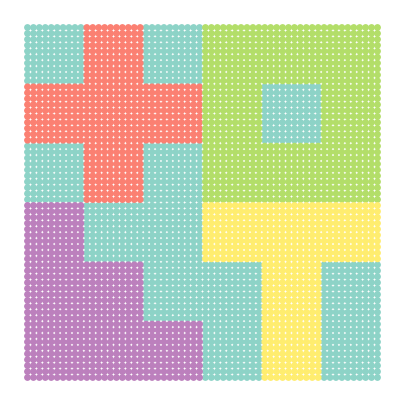

In [457]:
data, labels = make_dataset()
show_dataset(data, labels)

100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


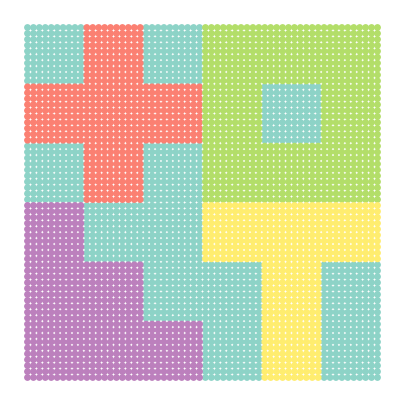

In [625]:
model = GibbsLDA(n_topics=5)
topics = model.fit_predict(data[:, 3:])
show_dataset(data, topics)

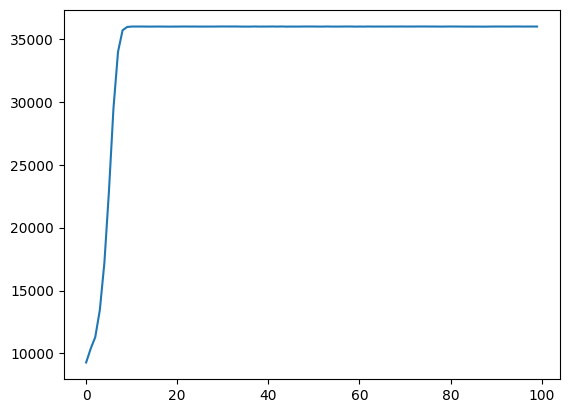

In [626]:
arr = np.arange(len(model.log_))
plt.plot(arr, model.log_)
plt.show()

In [163]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

@singledispatch
def relabel(labels, target=None):
    unique, inverse = np.unique_inverse(labels)

    if target is None:
        scores = np.eye(inverse.shape[0])[inverse, :inverse.max() + 1]
    else:
        labels, target = relabel(labels), np.unique_inverse(target)[-1]
        unique, inverse = np.unique_inverse(labels)
        scores = confusion_matrix(target[:labels.shape[0]], labels)

    _, mask = linear_sum_assignment(scores, maximize=True)
    labels = (labels[None] == unique[mask[mask < len(unique)], None]).argmax(0)

    return labels

@relabel.register(torch.Tensor)
def _(labels, target=None):
    unique, inverse = labels.unique(return_inverse=True)

    if target is None:
        scores = torch.eye(inverse.shape[0])[inverse, :inverse.max() + 1]
    else:
        labels, target = relabel(labels), target.unique(return_inverse=True)[-1]
        unique, inverse = labels.unique(return_inverse=True)
        scores = confusion_matrix(target[:labels.shape[0]], labels)

    _, mask = linear_sum_assignment(scores, maximize=True)
    labels = (labels[None] == unique[mask[mask < len(unique)], None]).float().argmax(0)

    return labels

arr = np.array([0, 0, 0, 0, 5, 5, 5, 5, 1, 1, 1])
brr = np.array([235, 1, 1, 12, 1, 0, 0, 0, 0, 2, 3, 3, 4])

relabel(arr, brr)

array([1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2])

In [140]:
np.unique(brr, return_inverse=True)[-1]

array([0, 0, 0, 0, 1, 1, 1, 2, 3, 3, 4])

In [139]:
np.unique_inverse(brr)[-1]

array([0, 0, 0, 0, 1, 1, 1, 2, 3, 3, 4])

In [131]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(GibbsLDA(n_topics=3), on_fail='warn')

100%|██████████| 100/100 [00:00<00:00, 356.56it/s]


[{'estimator': GibbsLDA(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': GibbsLDA(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': GibbsLDA(),
  'check_name': 'check_estimator_tags_renamed',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': GibbsLDA(),
  'check_name': 'check_valid_tag_types',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': GibbsLDA(),
  'check_name': 'check_estimator_repr',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Chec

In [29]:
type(data)

numpy.ndarray

In [167]:
model = GibbsLDA()
topics = model.fit_predict(data, verbosity=2)
show_dataset(data, topics)

LDA  step:0  likelihood: 9305.977176044453
LDA  step:10  likelihood: 33131.70101207632


KeyboardInterrupt: 

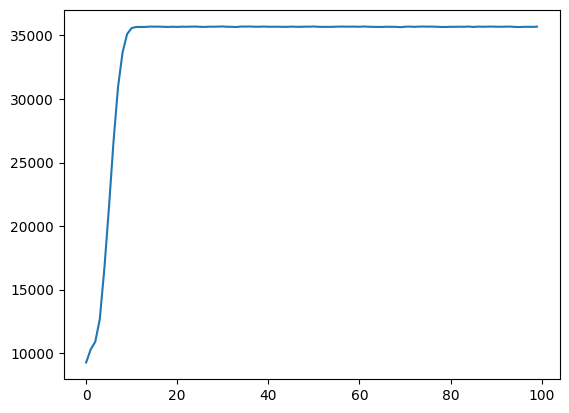

In [122]:
arr = np.arange(len(model.log))
plt.plot(arr, model.log)
plt.show()